# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [1]:

import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import warnings
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb 
import optuna 
from imblearn.datasets import make_imbalance
from catboost import CatBoostClassifier
import catboost as cb

#import hyperopt
import sys
from frozendict import frozendict
import shap
shap.initjs()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE, SVMSMOTE


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

from imblearn.pipeline import Pipeline

import datetime as dt
from category_encoders import target_encoder
import re

from typing import Tuple
import xgboost as xgb

from optuna.samplers import TPESampler
from catboost import Pool
import random
import multiprocessing
from sklearn.utils import resample

warnings.filterwarnings('ignore')

In [2]:
n_trials = int(100)
SEED = 123

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(SEED)

### Read files

In [3]:
# Load files into a pandas dataframe

train = pd.read_csv('data/zindi_challenge/Train.csv')
test = pd.read_csv('data/zindi_challenge/Test.csv')
ss = pd.read_csv('data/zindi_challenge/SampleSubmission.csv')
other_ds = pd.read_csv('data/zindi_challenge/NigerianStateNames.csv')

### Some basic EDA

In [4]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [5]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [6]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [7]:
other_ds.head()

,LGA,State
0,Abadam,Borno State
1,Abaji,Federal Capital Territory
2,Abak,Akwa Ibom State
3,Abakaliki,Ebonyi State
4,Aba-North,Abia State


In [8]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


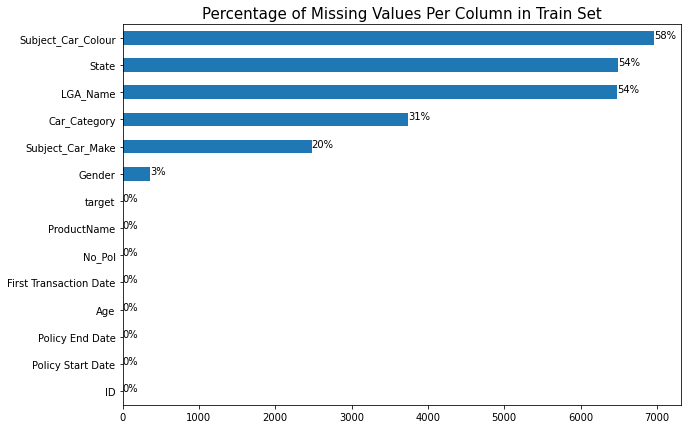

In [9]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

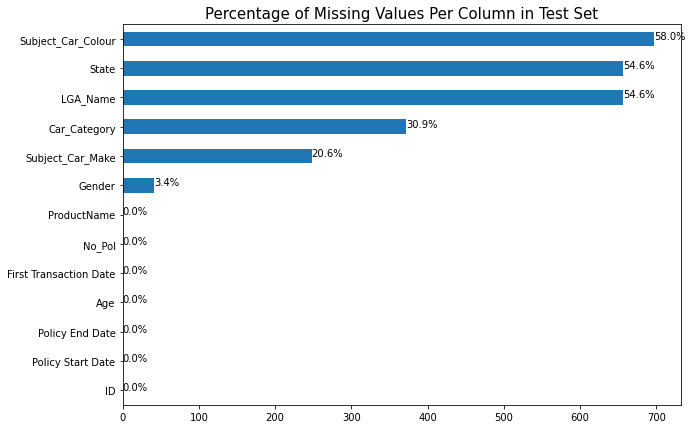

In [10]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [11]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [12]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [13]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [14]:
all_data = all_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
all_data.tail()

,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [15]:
all_data.columns

Index(['ID', 'PolicyStartDate', 'PolicyEndDate', 'Gender', 'Age',
       'FirstTransactionDate', 'No_Pol', 'Car_Category', 'Subject_Car_Colour',
       'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName', 'target'],
      dtype='object')

In [16]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
gen_cols = [col for col in all_data.columns if 'Gender' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    13281 non-null  object        
 1   PolicyStartDate       13281 non-null  datetime64[ns]
 2   PolicyEndDate         13281 non-null  datetime64[ns]
 3   Gender                12881 non-null  category      
 4   Age                   13281 non-null  int64         
 5   FirstTransactionDate  13281 non-null  datetime64[ns]
 6   No_Pol                13281 non-null  int64         
 7   Car_Category          9171 non-null   category      
 8   Subject_Car_Colour    5622 non-null   category      
 9   Subject_Car_Make      10557 non-null  category      
 10  LGA_Name              6149 non-null   category      
 11  State                 6137 non-null   category      
 12  ProductName           13281 non-null  category      
 13  target          

In [17]:
date_cols

['PolicyStartDate', 'PolicyEndDate', 'FirstTransactionDate']

### Distribution of the target variable

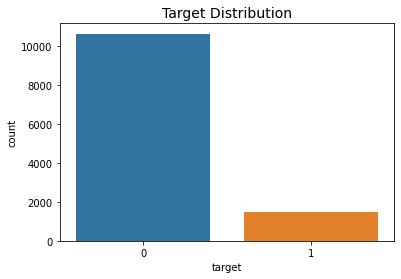

In [18]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

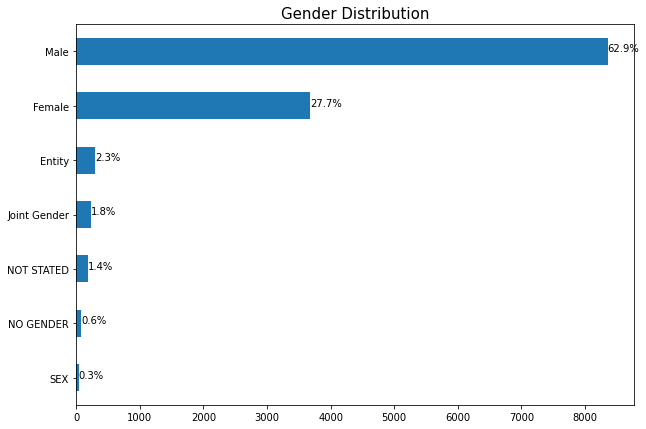

In [19]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [20]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

### Number of unique values per categorical column

In [21]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male', 'Female', 'Other', NaN]
Categories (3, object): ['Male', 'Female', 'Other'] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Saloon', 'JEEP', 'Motorcycle', 'Truck', ..., 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['Black', 'Grey', 'Red', 'As Attached', ..., 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['TOYOTA', 'REXTON', 'Lexus', 'Hyundai', ..., 'Buik', 'COMMANDER', 'Bajaj', 'Datsun'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa', ..., 'Hong', 'Ifako-

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

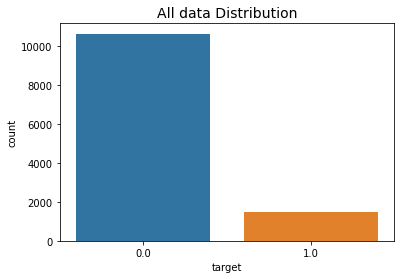

In [22]:
# all_data['target']  = all_data['target'].fillna(1)
# all_data['target'].isna().sum()

sns.countplot(all_data.target)
plt.title('All data Distribution', fontdict={'size':14});

### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [23]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,PolicyStartDateyear,PolicyStartDatemonth,PolicyStartDateday,PolicyEndDateyear,PolicyEndDatemonth,PolicyEndDateday,FirstTransactionDateyear,FirstTransactionDatemonth,FirstTransactionDateday
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,0.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,NaN,NaN,NaN,...,1.0,2010,8,29,2010,12,31,2010,8,29


In [24]:
all_data['dayofweek_PSD'] = all_data['PolicyStartDate'].dt.dayofweek
all_data['dayofweek_PED'] = all_data['PolicyEndDate'].dt.dayofweek

all_data.head()

,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,PolicyStartDatemonth,PolicyStartDateday,PolicyEndDateyear,PolicyEndDatemonth,PolicyEndDateday,FirstTransactionDateyear,FirstTransactionDatemonth,FirstTransactionDateday,dayofweek_PSD,dayofweek_PED
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,5,14,2011,5,13,2010,5,14,4,4
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,11,29,2011,11,28,2010,11,29,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,3,21,2011,3,20,2010,3,21,6,6
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,8,21,2011,8,20,2010,8,21,5,5
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,NaN,NaN,NaN,...,8,29,2010,12,31,2010,8,29,6,4


In [25]:
def weekend_psd(row):
    if row['dayofweek_PSD'] in [5, 6]:
        return 1
    return 0

def weekend_ped(row):
    if row['dayofweek_PED'] in [5, 6]:
        return 1
    return 0

all_data['weekend_psd'] = all_data.apply(weekend_psd, axis=1)
all_data['weekend_ped'] = all_data.apply(weekend_ped, axis=1)

all_data.head(n=20)


,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,PolicyEndDateyear,PolicyEndDatemonth,PolicyEndDateday,FirstTransactionDateyear,FirstTransactionDatemonth,FirstTransactionDateday,dayofweek_PSD,dayofweek_PED,weekend_psd,weekend_ped
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,2011,5,13,2010,5,14,4,4,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,2011,11,28,2010,11,29,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,2011,3,20,2010,3,21,6,6,1,1
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,2011,8,20,2010,8,21,5,5,1,1
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,NaN,NaN,NaN,...,2010,12,31,2010,8,29,6,4,1,0
5,ID_00D3EF6,2010-10-21,2011-10-20,Male,37,2010-10-21,2,NaN,NaN,NaN,...,2011,10,20,2010,10,21,3,3,0,0
6,ID_00HHZ8Y,2010-08-02,2011-08-01,Female,40,2010-08-02,3,NaN,NaN,NaN,...,2011,8,1,2010,8,2,0,0,0,0
7,ID_00M1X6U,2010-09-12,2011-09-11,Male,43,2010-09-12,1,Saloon,NaN,TOYOTA,...,2011,9,11,2010,9,12,6,6,1,1
8,ID_00N7XT1,2010-07-06,2011-07-05,Female,71,2010-07-06,2,JEEP,Black,REXTON,...,2011,7,5,2010,7,6,1,1,0,0
9,ID_00QF156,2010-12-18,2011-12-17,Female,58,2010-12-18,1,NaN,NaN,NaN,...,2011,12,17,2010,12,18,5,5,1,1


In [26]:
all_data[date_cols].tail()

,PolicyStartDate,PolicyEndDate,FirstTransactionDate
13276,2010-12-05,2011-12-04,2010-12-05
13277,2010-01-14,2011-01-13,2010-01-14
13278,2010-07-26,2011-07-25,2010-07-26
13279,2010-02-16,2011-02-15,2010-02-16
13280,2010-03-18,2011-03-17,2010-03-18


In [27]:
all_data_ = all_data.copy()
all_data_

,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,PolicyEndDateyear,PolicyEndDatemonth,PolicyEndDateday,FirstTransactionDateyear,FirstTransactionDatemonth,FirstTransactionDateday,dayofweek_PSD,dayofweek_PED,weekend_psd,weekend_ped
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,2011,5,13,2010,5,14,4,4,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,2011,11,28,2010,11,29,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,2011,3,20,2010,3,21,6,6,1,1
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,2011,8,20,2010,8,21,5,5,1,1
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,NaN,NaN,NaN,...,2010,12,31,2010,8,29,6,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,...,2011,12,4,2010,12,5,6,6,1,1
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,...,2011,1,13,2010,1,14,3,3,0,0
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,...,2011,7,25,2010,7,26,0,0,0,0
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,...,2011,2,15,2010,2,16,1,1,0,0


In [28]:
def create_extra_features(data):
    data['PolicyLengthDays'] = (pd.to_datetime(data['PolicyEndDate'], format = '%Y-%m-%d') - 
                         pd.to_datetime(data['PolicyStartDate'], format = '%Y-%m-%d')) / np.timedelta64(1, 'D')
    data['PolicyLengthMonths'] = (pd.to_datetime(data['PolicyEndDate'], format = '%Y-%m-%d') - 
                         pd.to_datetime(data['PolicyStartDate'], format = '%Y-%m-%d')) / np.timedelta64(1, 'M')
    data['PRatio_PL_NPL'] = data['PolicyLengthMonths']/(4*data['No_Pol'])

    data['NANs_cnt'] = data.isnull().sum(axis = 1)
    
    
def create_col_with_min_freq(data, col, min_freq = 10):
    data[col + '_fixed'] = data[col].astype(str)
    data.loc[data[col + '_fixed'].value_counts()[data[col + '_fixed']].values < min_freq, col + '_fixed'] = "RARE_VALUE"

    data.replace({'nan': np.nan}, inplace = True)

def create_gr_feats(data):
    num_cols = all_data._get_numeric_data().columns.tolist()
    cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target', 'PolicyLengthDays','PolicyLengthMonths']]
    for cat_col in cat_cols:
        create_col_with_min_freq(data, cat_col, 25)
        for num_col in num_cols:
            for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
                data['FIXED_' + n + '_' + num_col + '_by_' + cat_col] = data.groupby(cat_col + '_fixed')[num_col].transform(f)
    for col in ['PolicyStartDate', 'Gender', 'Age', 'No_Pol', 'Car_Category',
                   'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
                   'ProductName', 'PolicyLengthDays']:
        data[col + '_cnt'] = data[col].map(data[col].value_counts(dropna = False))
    

create_extra_features(all_data)
#create_gr_feats(all_data)
all_data.head()

,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,FirstTransactionDatemonth,FirstTransactionDateday,dayofweek_PSD,dayofweek_PED,weekend_psd,weekend_ped,PolicyLengthDays,PolicyLengthMonths,PRatio_PL_NPL,NANs_cnt
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,5,14,4,4,0,0,364.0,11.959178,2.989794,2
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,11,29,0,0,0,0,364.0,11.959178,2.989794,2
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,3,21,6,6,1,1,364.0,11.959178,2.989794,2
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,8,21,5,5,1,1,364.0,11.959178,2.989794,5
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,NaN,NaN,NaN,...,8,29,6,4,1,0,124.0,4.074006,0.339500,3


In [29]:
num_cols = all_data._get_numeric_data().columns.tolist()
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]
gen_cols = [col for col in all_data.columns if 'Gender' in col]
fixed_cols = [col for col in all_data.columns if 'fixed' in col]
cat_cols_efixed = [col for col in all_data.columns if col not in date_cols+fixed_cols+num_cols+['ID', 'target']]

all_data[fixed_cols]

""
0
1
2
3
4
...
13276
13277
13278
13279


In [30]:
all_data[cat_cols_efixed]

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,Male,Saloon,Black,TOYOTA,NaN,NaN,Car Classic
1,Female,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic
2,Male,Saloon,Red,TOYOTA,NaN,NaN,Car Classic
3,Male,NaN,NaN,NaN,NaN,NaN,CarSafe
4,Other,NaN,NaN,NaN,Lagos,Lagos,Muuve
...,...,...,...,...,...,...,...
13276,Male,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic
13277,Male,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic
13278,Male,Truck,White,Iveco,Victoria Island,Lagos,CVTP
13279,Male,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic


In [31]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum().sum()

0

In [32]:
all_data.target.value_counts()

# all_data['target_freq'] = all_data.groupby('target')['target'].transform('count')
# all_data['target_freq'] = all_data['target_freq']/len(all_data)

# encoder = target_encoder.TargetEncoder()
# all_data['target_type_mean'] = encoder.fit_transform(all_data['target'], all_data['Car_Category'])
all_data.isnull().sum().sum()

0

In [33]:
all_data[cat_cols].columns

Index(['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName'],
      dtype='object')

In [34]:
def target_encoding(cat_cols: list[str], df: pd.DataFrame, target:str):
    for col in cat_cols:
        encoder = target_encoder.TargetEncoder()
        df['target_'+col] = encoder.fit_transform(all_data[col],all_data[target])
    return df


 - Target encoding

In [35]:
# Encode categorical features
# all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data = target_encoding(cat_cols=cat_cols, df=all_data, target='target')

all_data.head()

,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,PolicyLengthMonths,PRatio_PL_NPL,NANs_cnt,target_Gender,target_Car_Category,target_Subject_Car_Colour,target_Subject_Car_Make,target_LGA_Name,target_State,target_ProductName
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,11.959178,2.989794,2,890.838511,903.860374,899.531289,902.33956,924.424548,906.194679,919.968776
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,11.959178,2.989794,2,956.783365,908.702654,902.787611,902.33956,924.424548,906.194679,919.968776
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,11.959178,2.989794,2,890.838511,903.860374,839.547445,902.33956,924.424548,906.194679,919.968776
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,...,11.959178,2.989794,5,890.838511,903.860374,899.531289,902.33956,924.424548,906.194679,914.692826
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,...,4.074006,0.339500,3,827.500000,903.860374,899.531289,902.33956,666.877778,906.194679,700.580000


In [36]:
all_data.columns.duplicated().sum()

0

In [37]:
# Separate train and test data from the combined dataframe
# train_df = all_data # got high f1 score but got bad submission score
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 38), (1202, 38))

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [38]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(date_cols+['ID', 'target']+gen_cols+cat_cols)
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, shuffle=True)

In [39]:
train_df[main_cols]

,Age,FirstTransactionDateday,FirstTransactionDatemonth,FirstTransactionDateyear,NANs_cnt,No_Pol,PRatio_PL_NPL,PolicyEndDateday,PolicyEndDatemonth,PolicyEndDateyear,...,dayofweek_PSD,target_Car_Category,target_Gender,target_LGA_Name,target_ProductName,target_State,target_Subject_Car_Colour,target_Subject_Car_Make,weekend_ped,weekend_psd
0,30,14,5,2010,2,1,2.989794,13,5,2011,...,4,903.860374,890.838511,924.424548,919.968776,906.194679,899.531289,902.339560,0,0
1,79,29,11,2010,2,1,2.989794,28,11,2011,...,0,908.702654,956.783365,924.424548,919.968776,906.194679,902.787611,902.339560,0,0
2,43,21,3,2010,2,1,2.989794,20,3,2011,...,6,903.860374,890.838511,924.424548,919.968776,906.194679,839.547445,902.339560,1,1
3,2,21,8,2010,5,1,2.989794,20,8,2011,...,5,903.860374,890.838511,924.424548,914.692826,906.194679,899.531289,902.339560,1,1
4,20,29,8,2010,3,3,0.339500,31,12,2010,...,6,903.860374,827.500000,666.877778,700.580000,906.194679,899.531289,902.339560,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,30,25,5,2010,1,1,2.989794,24,5,2011,...,1,903.860374,956.783365,465.232558,919.968776,465.232558,899.531289,991.702479,0,0
12075,59,3,10,2010,5,1,2.989794,2,10,2011,...,6,903.860374,956.783365,924.424548,919.968776,906.194679,899.531289,902.339560,1,1
12076,34,10,10,2010,5,1,2.981581,8,10,2011,...,6,903.860374,890.838511,924.424548,914.692826,906.194679,899.531289,902.339560,1,1
12077,120,27,2,2010,2,2,1.494897,26,2,2011,...,5,903.860374,890.838511,924.424548,786.011788,906.194679,872.380062,902.339560,1,1


In [40]:

X_ = train_df[main_cols].squeeze()
y_ = train_df.target.squeeze()

us = RandomUnderSampler(0.2)
os_ROS = RandomOverSampler(0.95, random_state=42)
os_smote = SMOTE(k_neighbors=3, random_state=42)
os_BLS = BorderlineSMOTE(k_neighbors=7)
os_SVMS = SVMSMOTE(k_neighbors=2)
os_ADASYN = ADASYN(n_neighbors=3)


X_os_smote, y_os_smote = os_smote.fit_resample(X_, y_)

X_train_os_smote, X_test_os_smote, y_train_os_smote, y_test_os_smote = train_test_split(X_os_smote,y_os_smote,
                                                                                test_size=0.3, 
                                                                                random_state=42,
                                                                                shuffle=True)

In [41]:
print(X_os_smote.columns.duplicated().sum()) # check for duplicated colum

0


In [42]:
# X_os_ROS, y_os_ROS = os_ROS.fit_resample(X_, y_)
# X_train_os_ROS, X_test_os_ROS, y_train_os_ROS, y_test_os_ROS = train_test_split(X_os_ROS,y_os_ROS,
#                                                                                 test_size=0.3, 
#                                                                                 random_state=42)

# X_os_smote, y_os_smote = os_smote.fit_resample(X_, y_)
# X_train_os_smote, X_test_os_smote, y_train_os_smote, y_test_os_smote = train_test_split(X_os_smote,y_os_smote,
#                                                                                 test_size=0.3, 
#                                                                                 random_state=42)

# X_os_smote, y_os_smote = os_smote.fit_resample(X_, y_)
# X_train_os_smote, X_test_os_smote, y_train_os_smote, y_test_os_smote = train_test_split(X_os_smote,y_os_smote,
#                                                                                 test_size=0.3, 
#                                                                                 random_state=42)

# X_os_BLS, y_os_BLS = os_BLS.fit_resample(X_, y_)
# X_train_os_BLS, X_test_os_BLS, y_train_os_BLS, y_test_os_BLS = train_test_split(X_os_BLS,y_os_BLS,
#                                                                                 test_size=0.3, 
#                                                                                 random_state=42)

# X_os_SVMS, y_os_SVMS = os_SVMS.fit_resample(X_, y_)
# X_train_os_SVMS, X_test_os_SVMS, y_train_os_SVMS, y_test_os_SVMS = train_test_split(X_os_SVMS,y_os_SVMS,
#                                                                                 test_size=0.3, 
#                                                                                 random_state=42)

# X_os_ADASYN, y_os_ADASYN = os_ADASYN.fit_resample(X_, y_)
# X_train_os_ADASYN, X_test_os_ADASYN, y_train_os_ADASYN, y_test_os_ADASYN = train_test_split(X_os_ADASYN,y_os_ADASYN,
#                                                                                 test_size=0.3, 
#                                                                                 random_state=42)


# X_us, y_us = us.fit_resample(X_, y_)
# X_train_u,X_test_u, y_train_u, y_test_u = train_test_split(X_us,y_us,
#                                                            test_size=0.3, 
#                                                            random_state=42)                                                               

In [ ]:


def f1_eval(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    y = dtrain.get_label()

    # convert the predicted values from {predt E R | 0<predt<1} to {0, 1} with a threshold of 0.5
    # all values less than 0.5 would be converted to 0 (False) and
    # all values equal or greater than 0.5 would be converted to 1 (True)
    predt_binary = np.where(predt > 0.51, 1, 0)
    return "F1_score", f1_score(y_true=y, y_pred=predt_binary)


dtrain = xgb.DMatrix(X_train_os_smote, label=y_train_os_smote)
dtest = xgb.DMatrix(X_test_os_smote, label=y_test_os_smote)

# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)


def objective(trial):
    # parameters for hypertunning 
    params = {"booster": "gbtree",
              'n_estimators': trial.suggest_int('n_estimators',400, 600),
              'max_depth': trial.suggest_int('max_depth', 10, 20),
              "eval_metric": "auc",
              'learning_rate': trial.suggest_uniform('learning_rate', 0.01, .1),
              'subsample' : trial.suggest_uniform('subsample', 0.50, 1),
              'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
              'gamma': trial.suggest_int('gamma', 0, 10),
              "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
              "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
              'objective': 'binary:logistic',}
              #'tree_method': 'gpu_hist',}
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    best = xgb.train(params, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback], feval=f1_eval)
    best.save_model('xgb_zindi.model')
    preds = np.rint(best.predict(dtest))
    f1_score_ = f1_score(y_test_os_smote, preds)
    return f1_score_


study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=100)

In [ ]:
print(study.best_trial.params)

best_params = study.best_trial.params
best_params['objective'] = 'binary:logistic'
best_params['missing'] = -999
best_params['random_state'] = 2020
#best_params['tree_method'] = 'gpu_hist'

In [ ]:

model_xgb = xgb.XGBClassifier(**best_params)
model_xgb.fit(X_train_os_smote, y_train_os_smote)
# Make predictions
y_pred = model_xgb.predict(X_test_os_smote)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test_os_smote, y_pred)}')
print(f'Accuracy score on the X_test is: {accuracy_score(y_test_os_smote, y_pred)}')

from sklearn.metrics import confusion_matrix, classification_report, recall_score

print(confusion_matrix(y_test_os_smote, y_pred))
print(classification_report(y_test_os_smote, y_pred))
print(recall_score(y_test_os_smote, y_pred, pos_label=1))

In [ ]:
%time shap_values = shap.TreeExplainer(model_xgb).shap_values(X_test_os_smote)

shap.summary_plot(shap_values, X_test_os_smote)

In [43]:
dtrain = lgb.Dataset(X_train_os_smote, label=y_train_os_smote)

def f1_eval_(predt: np.ndarray, dtrain: lgb.Dataset) -> Tuple[str, float]:
    y = dtrain.get_label()

    # convert the predicted values from {predt E R | 0<predt<1} to {0, 1} with a threshold of 0.5
    # all values less than 0.5 would be converted to 0 (False) and
    # all values equal or greater than 0.5 would be converted to 1 (True)
    predt_binary = np.where(predt > 0.5, 1, 0)
    return "F1_score", f1_score(y_true=y, y_pred=predt_binary)



def objective(trial):

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "feature_pre_filter": False,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 1, 1000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.9),
        'subsample': trial.suggest_uniform('subsample', 0,1),
        'max_depth': trial.suggest_int('max_depth', 10,100),
        'min_child_weight' : trial.suggest_loguniform('min_child_weight' , 1e-5 , 1),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
        'cat_l2': trial.suggest_int('cat_l2',1,20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'random_state': 2021,
        'n_estimators': 10000,
    }
    
    gbm = lgb.train(param, dtrain, feval=f1_eval_,)
    preds = np.rint(gbm.predict(X_test_os_smote))
    accuracy = accuracy_score(y_test_os_smote, preds,)
    f1_score_ = f1_score(y_test_os_smote, preds)
    f1_score(y_test_os_smote, preds)
    return f1_score_
    # gbm = lgb.LGBMClassifier(**param)  
    
    # gbm.fit(X_train_os_smote,y_train_os_smote,eval_set=[(X_test_os_smote,y_test_os_smote)],
    #         early_stopping_rounds=200,verbose=False)
    # preds = np.rint(gbm.predict(X_test_os_smote))
    # accuracy = accuracy_score(y_test_os_smote, preds,)
    # f1_score_ = f1_score(y_test_os_smote, preds)
    # return f1_score_

#study = optuna.create_study(direction="maximize")
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed=int(SEED)))

study.optimize(objective, n_trials=100)

best_params_ = study.best_trial.params

[I 2021-07-15 13:33:55,100] A new study created in memory with name: no-name-295ced4d-9ea3-4ef1-acd7-4b5ee885b952


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:35:17,868] Trial 0 finished with value: 0.9060203283815481 and parameters: {'lambda_l1': 0.01854482205182914, 'lambda_l2': 3.760572921733364e-06, 'learning_rate': 0.021631523301351215, 'num_leaves': 552, 'feature_fraction': 0.8316813818713378, 'bagging_fraction': 0.6538638760746767, 'bagging_freq': 10, 'min_child_samples': 206, 'reg_alpha': 0.007684071705306552, 'reg_lambda': 0.0022527090779355333, 'colsample_bytree': 0.37454241292069557, 'subsample': 0.7290497073840416, 'max_depth': 49, 'min_child_weight': 1.9878768816800643e-05, 'cat_smooth': 40, 'cat_l2': 15, 'min_data_per_group': 77}. Best is trial 0 with value: 0.9060203283815481.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:37:09,229] Trial 1 finished with value: 0.9037499999999999 and parameters: {'lambda_l1': 3.793724640322306e-07, 'lambda_l2': 0.0006080823033339466, 'learning_rate': 0.06103428098763377, 'num_leaves': 635, 'feature_fraction': 0.9096590764466738, 'bagging_fraction': 0.8346731949163811, 'bagging_freq': 7, 'min_child_samples': 217, 'reg_alpha': 0.0008664699052148586, 'reg_lambda': 0.0014816032900504092, 'colsample_bytree': 0.28261058470316447, 'subsample': 0.29371404638882936, 'max_depth': 67, 'min_child_weight': 2.887517996963759e-05, 'cat_smooth': 44, 'cat_l2': 9, 'min_data_per_group': 124}. Best is trial 0 with value: 0.9060203283815481.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:39:20,790] Trial 2 finished with value: 0.9029416391379582 and parameters: {'lambda_l1': 6.79943165296276e-05, 'lambda_l2': 6.461762725131424e-06, 'learning_rate': 0.042635619478693695, 'num_leaves': 894, 'feature_fraction': 0.9664960109223277, 'bagging_fraction': 0.7011020055306019, 'bagging_freq': 7, 'min_child_samples': 35, 'reg_alpha': 0.0008011482547107112, 'reg_lambda': 0.0030828846241938933, 'colsample_bytree': 0.7930473263066927, 'subsample': 0.2504553653965067, 'max_depth': 53, 'min_child_weight': 0.8468352511202689, 'cat_smooth': 52, 'cat_l2': 13, 'min_data_per_group': 68}. Best is trial 0 with value: 0.9060203283815481.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:40:13,915] Trial 3 finished with value: 0.9042935206869633 and parameters: {'lambda_l1': 0.2735692026087082, 'lambda_l2': 0.0026763392031222675, 'learning_rate': 0.06384568305187326, 'num_leaves': 343, 'feature_fraction': 0.5824724734163105, 'bagging_fraction': 0.6502133266148209, 'bagging_freq': 7, 'min_child_samples': 263, 'reg_alpha': 0.01154872459805984, 'reg_lambda': 0.10372482189387845, 'colsample_bytree': 0.5687492420497703, 'subsample': 0.6249035020955999, 'max_depth': 71, 'min_child_weight': 0.16282166373084725, 'cat_smooth': 9, 'cat_l2': 16, 'min_data_per_group': 86}. Best is trial 0 with value: 0.9060203283815481.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:41:17,065] Trial 4 finished with value: 0.907981220657277 and parameters: {'lambda_l1': 5.597661665007215e-07, 'lambda_l2': 0.0014194255469123856, 'learning_rate': 0.013847742928314727, 'num_leaves': 886, 'feature_fraction': 0.7763493832307613, 'bagging_fraction': 0.8340498149139728, 'bagging_freq': 1, 'min_child_samples': 179, 'reg_alpha': 0.021913470039770032, 'reg_lambda': 8.989962183537838e-05, 'colsample_bytree': 0.22245641209981848, 'subsample': 0.6955295287709109, 'max_depth': 39, 'min_child_weight': 0.028830453752968888, 'cat_smooth': 56, 'cat_l2': 8, 'min_data_per_group': 189}. Best is trial 4 with value: 0.907981220657277.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:43:15,638] Trial 5 finished with value: 0.9087195600942655 and parameters: {'lambda_l1': 0.37586334306608105, 'lambda_l2': 1.6465620446426067e-05, 'learning_rate': 0.011598180884698996, 'num_leaves': 305, 'feature_fraction': 0.6389114091507886, 'bagging_fraction': 0.8229752982708174, 'bagging_freq': 10, 'min_child_samples': 107, 'reg_alpha': 0.3760857539180611, 'reg_lambda': 0.036229429838882325, 'colsample_bytree': 0.6533614389601416, 'subsample': 0.15112745234808023, 'max_depth': 46, 'min_child_weight': 0.0001600587749607852, 'cat_smooth': 35, 'cat_l2': 11, 'min_data_per_group': 150}. Best is trial 5 with value: 0.9087195600942655.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:44:42,475] Trial 6 finished with value: 0.9070387208026336 and parameters: {'lambda_l1': 8.97793311290013e-08, 'lambda_l2': 1.5067963377209236e-07, 'learning_rate': 0.02989540198065364, 'num_leaves': 662, 'feature_fraction': 0.9079037351624333, 'bagging_fraction': 0.731954406878028, 'bagging_freq': 9, 'min_child_samples': 116, 'reg_alpha': 0.0007956597385069873, 'reg_lambda': 0.0013353283009882753, 'colsample_bytree': 0.23686546336407927, 'subsample': 0.8291126345018904, 'max_depth': 40, 'min_child_weight': 0.0057789691553455196, 'cat_smooth': 58, 'cat_l2': 11, 'min_data_per_group': 50}. Best is trial 5 with value: 0.9087195600942655.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:44:58,809] Trial 7 finished with value: 0.9066037735849055 and parameters: {'lambda_l1': 7.854323296284444, 'lambda_l2': 1.4062877087512982, 'learning_rate': 0.02026298130842371, 'num_leaves': 293, 'feature_fraction': 0.7120060918434901, 'bagging_fraction': 0.9411468235964023, 'bagging_freq': 10, 'min_child_samples': 78, 'reg_alpha': 0.024330680598117802, 'reg_lambda': 0.6947236840861114, 'colsample_bytree': 0.4154960431622199, 'subsample': 0.7310730358445571, 'max_depth': 24, 'min_child_weight': 0.010080749876583002, 'cat_smooth': 87, 'cat_l2': 20, 'min_data_per_group': 61}. Best is trial 5 with value: 0.9087195600942655.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:45:49,739] Trial 8 finished with value: 0.9048964218455744 and parameters: {'lambda_l1': 7.163503415742813e-05, 'lambda_l2': 6.932433877630997e-07, 'learning_rate': 0.04630679657649888, 'num_leaves': 548, 'feature_fraction': 0.4559960262218925, 'bagging_fraction': 0.5781164652884077, 'bagging_freq': 10, 'min_child_samples': 171, 'reg_alpha': 0.005552288000449261, 'reg_lambda': 0.33201365433430763, 'colsample_bytree': 0.6934897214736299, 'subsample': 0.04857903284426879, 'max_depth': 74, 'min_child_weight': 0.15711467052621755, 'cat_smooth': 17, 'cat_l2': 16, 'min_data_per_group': 93}. Best is trial 5 with value: 0.9087195600942655.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:47:15,884] Trial 9 finished with value: 0.9097744360902257 and parameters: {'lambda_l1': 5.730965314225318e-06, 'lambda_l2': 0.009712995513834142, 'learning_rate': 0.014606284121683532, 'num_leaves': 665, 'feature_fraction': 0.9327140756057336, 'bagging_fraction': 0.8177867609412438, 'bagging_freq': 5, 'min_child_samples': 132, 'reg_alpha': 0.3895619861980671, 'reg_lambda': 0.02476577981101061, 'colsample_bytree': 0.1679233305534541, 'subsample': 0.5826710878614046, 'max_depth': 84, 'min_child_weight': 0.0004845425463181468, 'cat_smooth': 93, 'cat_l2': 16, 'min_data_per_group': 136}. Best is trial 9 with value: 0.9097744360902257.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:47:38,610] Trial 10 finished with value: 0.8922165028856653 and parameters: {'lambda_l1': 7.026137044976455e-06, 'lambda_l2': 0.32104522051561507, 'learning_rate': 0.18553981747908807, 'num_leaves': 9, 'feature_fraction': 0.9928650935890768, 'bagging_fraction': 0.4038720245318976, 'bagging_freq': 3, 'min_child_samples': 286, 'reg_alpha': 8.274358593933712, 'reg_lambda': 9.753340221660716, 'colsample_bytree': 0.14713559344775573, 'subsample': 0.9632278722400942, 'max_depth': 99, 'min_child_weight': 0.0006377720996166494, 'cat_smooth': 100, 'cat_l2': 4, 'min_data_per_group': 176}. Best is trial 9 with value: 0.9097744360902257.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:49:20,724] Trial 11 finished with value: 0.9095461658841941 and parameters: {'lambda_l1': 0.0069471858976700215, 'lambda_l2': 3.996349375599102e-05, 'learning_rate': 0.010051446382217714, 'num_leaves': 199, 'feature_fraction': 0.6029464389017309, 'bagging_fraction': 0.9967026947485087, 'bagging_freq': 4, 'min_child_samples': 106, 'reg_alpha': 1.724455092106381, 'reg_lambda': 0.027802271764972512, 'colsample_bytree': 0.5953961532840737, 'subsample': 0.42849999818961776, 'max_depth': 95, 'min_child_weight': 0.0002766681823773257, 'cat_smooth': 79, 'cat_l2': 20, 'min_data_per_group': 152}. Best is trial 9 with value: 0.9097744360902257.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:51:56,228] Trial 12 finished with value: 0.914078511745231 and parameters: {'lambda_l1': 0.0031005199712295342, 'lambda_l2': 0.04518222339299327, 'learning_rate': 0.011144518585879695, 'num_leaves': 182, 'feature_fraction': 0.49895570928627553, 'bagging_fraction': 0.9863480269150506, 'bagging_freq': 4, 'min_child_samples': 12, 'reg_alpha': 3.2013225158169756, 'reg_lambda': 2.975683147048802, 'colsample_bytree': 0.535866247851432, 'subsample': 0.4682736771125858, 'max_depth': 100, 'min_child_weight': 0.0004575688755608657, 'cat_smooth': 81, 'cat_l2': 20, 'min_data_per_group': 135}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:52:43,743] Trial 13 finished with value: 0.9041699449252557 and parameters: {'lambda_l1': 0.0012125854138529829, 'lambda_l2': 0.046371041156977766, 'learning_rate': 0.12806075279013152, 'num_leaves': 27, 'feature_fraction': 0.40808433759130114, 'bagging_fraction': 0.9372036651042622, 'bagging_freq': 4, 'min_child_samples': 1, 'reg_alpha': 1.1219612194218429e-05, 'reg_lambda': 5.4161527729344625, 'colsample_bytree': 0.44069878089762904, 'subsample': 0.4860801617092624, 'max_depth': 87, 'min_child_weight': 0.0009301809121691436, 'cat_smooth': 99, 'cat_l2': 20, 'min_data_per_group': 114}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:55:42,436] Trial 14 finished with value: 0.9126121870571563 and parameters: {'lambda_l1': 1.0187723716950256e-05, 'lambda_l2': 9.594821740916242, 'learning_rate': 0.01743937063877179, 'num_leaves': 752, 'feature_fraction': 0.49847280466784305, 'bagging_fraction': 0.9750527363140031, 'bagging_freq': 2, 'min_child_samples': 14, 'reg_alpha': 0.35858764123915493, 'reg_lambda': 2.6935606113619404e-05, 'colsample_bytree': 0.8791691251192087, 'subsample': 0.39529513380582565, 'max_depth': 86, 'min_child_weight': 7.116089758013328e-05, 'cat_smooth': 74, 'cat_l2': 18, 'min_data_per_group': 149}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 13:59:15,138] Trial 15 finished with value: 0.9129886506935687 and parameters: {'lambda_l1': 0.0008901906555895876, 'lambda_l2': 8.013358777169433, 'learning_rate': 0.021713057150426218, 'num_leaves': 764, 'feature_fraction': 0.48745040266337797, 'bagging_fraction': 0.9926197406044108, 'bagging_freq': 1, 'min_child_samples': 6, 'reg_alpha': 4.654890629167297, 'reg_lambda': 8.999273766989563e-05, 'colsample_bytree': 0.8952209154461112, 'subsample': 0.35587335516505525, 'max_depth': 100, 'min_child_weight': 6.439171345416699e-05, 'cat_smooth': 72, 'cat_l2': 18, 'min_data_per_group': 166}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 14:00:53,137] Trial 16 finished with value: 0.9089481946624803 and parameters: {'lambda_l1': 0.0012034489185888233, 'lambda_l2': 7.430851567906525, 'learning_rate': 0.029846425434500758, 'num_leaves': 129, 'feature_fraction': 0.5231817774831673, 'bagging_fraction': 0.8981511849120901, 'bagging_freq': 2, 'min_child_samples': 56, 'reg_alpha': 8.219776419500963, 'reg_lambda': 0.00031376745308319244, 'colsample_bytree': 0.8951823828736832, 'subsample': 0.3323621288714741, 'max_depth': 99, 'min_child_weight': 0.0014349272965756613, 'cat_smooth': 70, 'cat_l2': 18, 'min_data_per_group': 169}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 14:02:42,753] Trial 17 finished with value: 0.9138364779874214 and parameters: {'lambda_l1': 0.04076119974927114, 'lambda_l2': 0.1358715499049724, 'learning_rate': 0.010631105379337372, 'num_leaves': 428, 'feature_fraction': 0.4133096492192147, 'bagging_fraction': 0.4678987861720618, 'bagging_freq': 1, 'min_child_samples': 1, 'reg_alpha': 2.576778037425471, 'reg_lambda': 1.277179322167224e-05, 'colsample_bytree': 0.7915931415620445, 'subsample': 0.1758662710954955, 'max_depth': 10, 'min_child_weight': 1.198331223231607e-05, 'cat_smooth': 65, 'cat_l2': 1, 'min_data_per_group': 103}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 14:03:37,064] Trial 18 finished with value: 0.9053820806527538 and parameters: {'lambda_l1': 0.1250725720666892, 'lambda_l2': 0.08793983127159354, 'learning_rate': 0.010339739317128397, 'num_leaves': 431, 'feature_fraction': 0.4492862657051607, 'bagging_fraction': 0.4496836854911822, 'bagging_freq': 5, 'min_child_samples': 62, 'reg_alpha': 1.2894006049079139, 'reg_lambda': 0.9516634547914432, 'colsample_bytree': 0.7618805880299432, 'subsample': 0.07932739343581413, 'max_depth': 11, 'min_child_weight': 2.0256472573759686e-05, 'cat_smooth': 63, 'cat_l2': 1, 'min_data_per_group': 101}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 14:03:48,486] Trial 19 finished with value: 0.9028301886792452 and parameters: {'lambda_l1': 9.717511737879237, 'lambda_l2': 0.6087808732048666, 'learning_rate': 0.09659947053195041, 'num_leaves': 433, 'feature_fraction': 0.5585199802510289, 'bagging_fraction': 0.5123369268949101, 'bagging_freq': 3, 'min_child_samples': 30, 'reg_alpha': 0.13178167137602526, 'reg_lambda': 2.445360649678642, 'colsample_bytree': 0.5078623192139851, 'subsample': 0.18958072374494905, 'max_depth': 10, 'min_child_weight': 1.1949356329889874e-05, 'cat_smooth': 27, 'cat_l2': 5, 'min_data_per_group': 114}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


[I 2021-07-15 14:05:03,415] Trial 20 finished with value: 0.8801256873527102 and parameters: {'lambda_l1': 0.01652688657284531, 'lambda_l2': 0.01597769099266044, 'learning_rate': 0.2851402381871414, 'num_leaves': 163, 'feature_fraction': 0.6707255301284508, 'bagging_fraction': 0.5298903750650725, 'bagging_freq': 6, 'min_child_samples': 79, 'reg_alpha': 1.373865820282359e-05, 'reg_lambda': 1.265294065497457e-05, 'colsample_bytree': 0.785220321813737, 'subsample': 0.5321145602864906, 'max_depth': 24, 'min_child_weight': 0.00339116675050448, 'cat_smooth': 89, 'cat_l2': 1, 'min_data_per_group': 129}. Best is trial 12 with value: 0.914078511745231.


[LightGBM] [Warning] bagging_fraction is set=0.6538638760746767, subsample=0.7290497073840416 will be ignored. Current value: bagging_fraction=0.6538638760746767
[LightGBM] [Warning] lambda_l2 is set=3.760572921733364e-06, reg_lambda=0.0022527090779355333 will be ignored. Current value: lambda_l2=3.760572921733364e-06
[LightGBM] [Warning] feature_fraction is set=0.8316813818713378, colsample_bytree=0.37454241292069557 will be ignored. Current value: feature_fraction=0.8316813818713378
[LightGBM] [Warning] lambda_l1 is set=0.01854482205182914, reg_alpha=0.007684071705306552 will be ignored. Current value: lambda_l1=0.01854482205182914


KeyboardInterrupt: 

In [ ]:
best_params_ = study.best_trial.params
best_params_

{'sample_type': 'auc',
 'lambda_l1': 1.0224722519801428e-08,
 'lambda_l2': 0.00038619144991908493,
 'learning_rate': 0.08798090965460281,
 'num_leaves': 596,
 'feature_fraction': 0.40333935931348847,
 'bagging_fraction': 0.9169539446129342,
 'bagging_freq': 8,
 'min_child_samples': 25,
 'reg_alpha': 0.030191940948413293,
 'reg_lambda': 1.2388810475437315,
 'colsample_bytree': 0.6408088374733765,
 'subsample': 0.20543062665424078,
 'max_depth': 18,
 'min_child_weight': 2.6551317363241817e-05,
 'cat_smooth': 91,
 'cat_l2': 15,
 'min_data_per_group': 164}

In [44]:
best_params_ = {'sample_type': 'auc',
 'lambda_l1': 1.0224722519801428e-08,
 'lambda_l2': 0.00038619144991908493,
 'learning_rate': 0.08798090965460281,
 'num_leaves': 596,
 'feature_fraction': 0.40333935931348847,
 'bagging_fraction': 0.9169539446129342,
 'bagging_freq': 8,
 'min_child_samples': 25,
 'reg_alpha': 0.030191940948413293,
 'reg_lambda': 1.2388810475437315,
 'colsample_bytree': 0.6408088374733765,
 'subsample': 0.20543062665424078,
 'max_depth': 18,
 'min_child_weight': 2.6551317363241817e-05,
 'cat_smooth': 91,
 'cat_l2': 15,
 'min_data_per_group': 164}

In [45]:

model_lgb = lgb.LGBMClassifier(**best_params_)
model_lgb.fit(X_train_os_smote, y_train_os_smote)
# Make predictions
y_pred = model_lgb.predict(X_test_os_smote)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test_os_smote, y_pred)}')
print(f'Accuracy score on the X_test is: {accuracy_score(y_test_os_smote, y_pred)}')

from sklearn.metrics import confusion_matrix, classification_report, recall_score

print(confusion_matrix(y_test_os_smote, y_pred))
print(classification_report(y_test_os_smote, y_pred))
print(recall_score(y_test_os_smote, y_pred, pos_label=1))

F1 score on the X_test is: 0.9140969162995595
Accuracy score on the X_test is: 0.9143529411764706
[[2924  266]
 [ 280 2905]]
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      3190
         1.0       0.92      0.91      0.91      3185

    accuracy                           0.91      6375
   macro avg       0.91      0.91      0.91      6375
weighted avg       0.91      0.91      0.91      6375

0.9120879120879121


CPU times: user 1min 37s, sys: 401 ms, total: 1min 38s
Wall time: 37.1 s


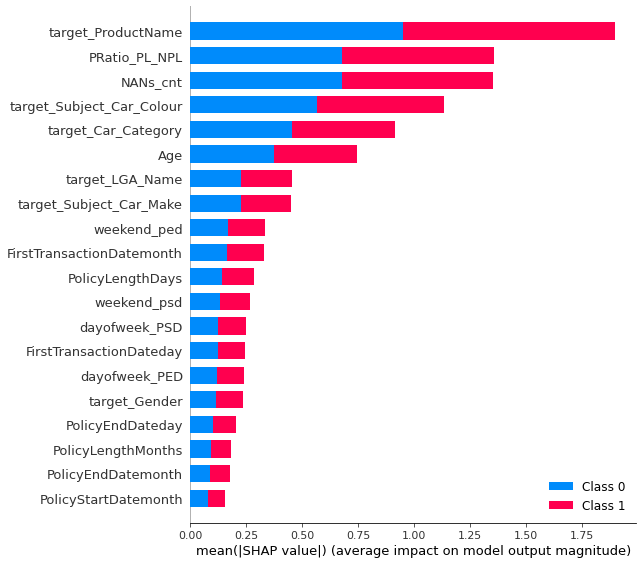

In [46]:
%time shap_values = shap.TreeExplainer(model_lgb).shap_values(X_test_os_smote)

shap.summary_plot(shap_values, X_test_os_smote)

In [ ]:
test_df = test_df[main_cols]
predictions = model_lgb.predict(test_df.values)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)


# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

In [ ]:
preds = np.zeros(test_df.shape[0])
kf = StratifiedKFold(n_splits = 10 , random_state = 7 , shuffle = True)
f1 =[]
acc = []
n=0

X_os_smote, y_os_smote
for tr_idx, test_idx in kf.split(X_os_smote, y_os_smote):
    
    X_tr, X_val = X_os_smote.iloc[tr_idx], X_os_smote.iloc[test_idx]
    y_tr, y_val = y_os_smote.iloc[tr_idx], y_os_smote.iloc[test_idx]
    
    model = LGBMClassifier(**best_params_)
    
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=500,verbose=False)
    
    preds+=model.predict(test_df[main_cols])
    f1.append(f1_score(y_val, model.predict(X_val)))
    acc.append(accuracy_score(y_val, model.predict(X_val)))
    print(f"{n+1},f1_Score:{f1[n]}, accracy:{acc[n]}")
    n+=1

preds//10

[LightGBM] [Warning] Unknown parameter: sample_type
[LightGBM] [Warning] feature_fraction is set=0.40333935931348847, colsample_bytree=0.6408088374733765 will be ignored. Current value: feature_fraction=0.40333935931348847
[LightGBM] [Warning] lambda_l1 is set=1.0224722519801428e-08, reg_alpha=0.030191940948413293 will be ignored. Current value: lambda_l1=1.0224722519801428e-08
[LightGBM] [Warning] lambda_l2 is set=0.00038619144991908493, reg_lambda=1.2388810475437315 will be ignored. Current value: lambda_l2=0.00038619144991908493
[LightGBM] [Warning] bagging_fraction is set=0.9169539446129342, subsample=0.20543062665424078 will be ignored. Current value: bagging_fraction=0.9169539446129342
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
1,f1_Score:0.912981455064194, accracy:0.9138823529411765
[LightGBM] [Warning] Unknown parameter: sample_type
[LightGBM] [Warning] feature_fraction is set=0.40333935931348847, colsample_bytree

array([0., 0., 0., ..., 0., 0., 1.])

In [ ]:
np.mean(f1), np.mean(acc)

(0.9126839077037239, 0.9127915808131164)

In [ ]:
# def score_model(probs, threshold):
#     return np.array([1 if x> threshold else 0 for x in probs])

# scores = score_model(preds, 60)


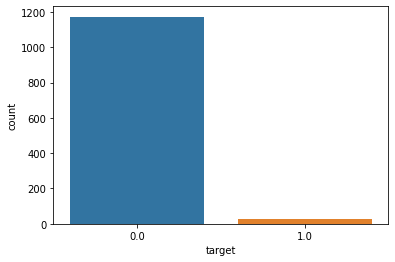

In [ ]:
# Make prediction on the test set. best resuts yet
# test_df = test_df[main_cols]
# predictions = clf.predict(test_df.values)

# Create a submission file
sub_file = ss.copy()
sub_file.target = (preds//10)

# Check the distribution of your predictions
sns.countplot(sub_file.target)


# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

array([0., 0., 0., ..., 0., 0., 1.])

## Catboost

In [ ]:
train_pool = Pool(X_train_os_smote, y_train_os_smote)
test_pool = Pool(X_test_os_smote, y_test_os_smote)

def objective(trial):
    
    # Parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }
    # Learning
    cbc = cb.CatBoostClassifier(
        loss_function="Logloss",
        eval_metric='F1',
        #task_type="GPU",
        l2_leaf_reg=50,
        random_seed=SEED,
        border_count=64,
        **params
    )        
    cbc.fit(train_pool, eval_set=test_pool,use_best_model=True)
    
    # Predict
    #preds = cb.predict(test_pool)
    pred = np.rint(cbc.predict(test_pool))
    y_pred = resample(pred, n_samples = len(y_test_os_smote))
    # Evaluation
    #ROC_AUC_Score = roc_auc_score(y_test_os_smote, y_pred)
    accuracy = accuracy_score(y_test_os_smote, y_pred,)
    f1_score_ = f1_score(y_test_os_smote, y_pred)
    #print('ROC AUC Score of CatBoost =', ROC_AUC_Score)
    return f1_score_

#study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed=int(SEED)))
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = n_trials,n_jobs = multiprocessing.cpu_count())

In [ ]:
print(study.best_trial.params)

best_params__ = study.best_trial.params

In [ ]:
model_cb = cb.CatBoostClassifier(**best_params__)
model_cb.fit(X_train_os_smote, y_train_os_smote)
# Make predictions
y_pred = model_cb.predict(X_test_os_smote)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test_os_smote, y_pred)}')
print(f'Accuracy score on the X_test is: {accuracy_score(y_test_os_smote, y_pred)}')

from sklearn.metrics import confusion_matrix, classification_report, recall_score

print(confusion_matrix(y_test_os_smote, y_pred))
print(classification_report(y_test_os_smote, y_pred))
print(recall_score(y_test_os_smote, y_pred, pos_label=1))

In [ ]:
%time shap_values = shap.TreeExplainer(model_cb).shap_values(X_test_os_smote)

shap.summary_plot(shap_values, X_test_os_smote)

In [ ]:
# stacking models 
from sklearn.ensemble import StackingClassifier


base_models = []

base_models.append(('lgb', lgb.LGBMClassifier(**best_params_)))
base_models.append(('xgb', xgb.XGBClassifier(**best_params)))
#base_models.append(('ctb',  cb.CatBoostClassifier(**best_params__)))

meta_model = lgb.LGBMClassifier(**best_params_)

model_cb = cb.CatBoostClassifier(**best_params__)
model_xgb = xgb.XGBClassifier(**best_params)
model_lgb = lgb.LGBMClassifier(**best_params_)

clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
# scores = cross_val_score(clf, X, y, cv=kfold)
# print(scores.mean())

clf.fit(X_train_os_smote, y_train_os_smote)

y_pred = clf.predict(X_test_os_smote)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test_os_smote, y_pred)}')
print(f'Accuracy score on the X_test is: {accuracy_score(y_test_os_smote, y_pred)}')

from sklearn.metrics import confusion_matrix, classification_report, recall_score

print(confusion_matrix(y_test_os_smote, y_pred))
print(classification_report(y_test_os_smote, y_pred))
print(recall_score(y_test_os_smote, y_pred, pos_label=1))

1202

In [ ]:


# Make prediction on the test set. best resuts yet
test_df = test_df[main_cols]
predictions = clf.predict(test_df.values)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)


# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

In [ ]:
# Make prediction on the test set. best resuts yet
test_df = test_df[main_cols]
predictions = model_lgb.predict(test_df.values)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)


# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

In [ ]:
base_file = pd.read_csv('Baseline_combo.csv')
base_file.head()

In [ ]:
sns.countplot(base_file.target)